#Mount Google Drive

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 2.x selected.
Note: using Google CoLab


#Install Retro & Imports

In [0]:
!pip3 install gym-retro # install OpenAI Gym-Retro

     |████████████████████████████████| 162.0MB 27kB/s 


In [0]:
import gym
import retro
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import os
from datetime import datetime, timedelta
from time import time

from tensorflow.keras.layers import Activation, Dense, Conv2D, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as kbe

#Install Roms

In [0]:
# install roms
romPath = '/content/drive/My Drive/Colab Notebooks/Roms/'
for rom in os.listdir(romPath):
  retro.data.merge(romPath + rom, quiet=False)

Importing SpaceInvaders-Nes
Imported 1 games
Importing Joust-Nes
Imported 1 games
Importing SuperMarioBros-Nes
Imported 1 games
Importing MsPacMan-Nes
Imported 1 games


#Environment Wrappers

In [0]:
# Discretize continuous action space
class Discretizer(gym.ActionWrapper):
  def __init__(self, env, combos):
    super().__init__(env)
    assert isinstance(env.action_space, gym.spaces.MultiBinary)
    buttons = env.unwrapped.buttons
    self._decode_discrete_action = []
    for combo in combos:
      arr = np.array([False] * env.action_space.n)
      for button in combo:
        arr[buttons.index(button)] = True
      self._decode_discrete_action.append(arr)

    self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

  def action(self, act):
    return self._decode_discrete_action[act].copy()

# Limit the episode length
class TimeLimit(gym.Wrapper):
  def __init__(self, env, max_episode_steps=None):
    super().__init__(env)
    self._max_episode_steps = max_episode_steps
    self._elapsed_steps = 0

  def step(self, action):
    obs, reward, done, info = self.env.step(action)
    self._elapsed_steps += 1
    if self._elapsed_steps >= self._max_episode_steps:
      done = True
      info['TimeLimit.truncated'] = True
    return obs, reward, done, info

  def reset(self, **kwargs):
    self._elapsed_steps = 0
    return self.env.reset(**kwargs)

# Skip frames
class SkipFrames(gym.Wrapper):
  def __init__(self, env, n = 4):
    gym.Wrapper.__init__(self, env)
    self.n = n

  def step(self, action):
    done = False
    totalReward = 0.0
    for _ in range(self.n):
      obs, reward, done, info = self.env.step(action)
      totalReward += reward
      if done:
        break
    return obs, totalReward, done, info

# Convert observation to greyscale
class Rgb2Gray(gym.ObservationWrapper):
  def __init__(self, env):
    gym.ObservationWrapper.__init__(self, env)
    (oldh, oldw, _oldc) = env.observation_space.shape
    self.observation_space = gym.spaces.Box(low = 0, high = 255,
                                            shape = (oldh, oldw, 1),
                                            dtype = np.uint8)
    
  def observation(self, frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    return frame[:,:,None]

# Downsample the observation
class Downsample(gym.ObservationWrapper):
    def __init__(self, env, ratio):
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (oldh//ratio, oldw//ratio, oldc)
        self.observation_space = gym.spaces.Box(low = 0, high = 255,
                                                shape = newshape,
                                                dtype = np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:, :, None]
        return frame

from collections import deque
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        (oldh, oldw, _oldc) = env.observation_space.shape
        newStackShape = (oldh, oldw, k)
        self.observation_space = gym.spaces.Box(low = 0, high = 255,
                                                shape = newStackShape,
                                                dtype = np.uint8)
        self.k = k
        self.frames = deque([], maxlen = k)

    def reset(self):
        obs = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs()

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        assert len(self.frames) == self.k
        return np.concatenate(self.frames, axis = 2)

class ScaledFloatFrame(gym.ObservationWrapper):
  def __init__(self, env):
    gym.ObservationWrapper.__init__(self, env)
    self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

  def observation(self, observation):
    return np.array(observation).astype(np.float32) / 255.0

# combine the wrappers
def make_env(game, state, scenario, record, obs_type, combos, timeLimit, downsampleRatio):
  env = retro.make(game=game, state=state, scenario=scenario, record=record, obs_type=obs_type)
  env = Discretizer(env, combos=combos)
  env = TimeLimit(env, timeLimit)
  env = SkipFrames(env)
  env = Rgb2Gray(env)
  env = Downsample(env, downsampleRatio)
  env = FrameStack(env, 4)
  env = ScaledFloatFrame(env)
  return env

#Utility functions

In [0]:
# Render avi or gif
def renderFrames(frame_array, savePath, fileName, fps, otype='AVI'):
  print('Creating replay ...', end=' ')
  if otype == 'AVI':
    fileName += '.avi'
    height, width, layers = frame_array[0].shape
    if layers == 1:
      layers = 0
    size = (width, height)
    out = cv2.VideoWriter(savePath + fileName, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, layers)
    for i in range(len(frame_array)):
      out.write(frame_array[i])
    out.release()
    print('Done. Saved to {}'.format(savePath + fileName))
  elif otype == 'GIF':
    fileName += '.gif'
    imageio.mimwrite(savePath + fileName, replay, fps=fps)
    print('Done. Saved to {}'.format(savePath + fileName))
  else:
    print('Error: Invalid type, must be GIF or AVI.')

# Get current date/time foramtted as string
def Now():
  # subtract 6 hours to get correct tz
  now = datetime.now() - timedelta(hours=6)
  return now.strftime('%m_%d_%Y_%H%M%S')

# save the log to file
def saveLog(savePath, fileName, log):
  print('Saving log ...', end=' ')
  fileName += '.log'
  f = open(savePath + fileName, 'w')
  for line in log:
    f.write(line + '\n')
  f.write(Now())
  f.close()
  print('Done. Saved to {}'.format(savePath + fileName))

#Agent
DQN agent modeled after code by YouTuber [Machine Learning with Phil](https://www.youtube.com/watch?v=5fHngyN8Qhw&t)

In [0]:
class ReplayBuffer():
  ''' Keeps track of states, actions, rewards, and terminal flags the agent encounters while playing game for sampling later. '''
  def __init__(self, max_size, input_shape):
    self.memory_size = max_size
    self.memory_cntr = 0
    self.state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
    self.new_state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
    self.action_memory = np.zeros(self.memory_size, dtype=np.int32)
    self.reward_memory = np.zeros(self.memory_size, dtype=np.float32)
    self.terminal_memory = np.zeros(self.memory_size, dtype=np.uint8)

  def store_transition(self, state, action, reward, new_state, done):
    index = self.memory_cntr % self.memory_size
    self.state_memory[index] = state
    self.new_state_memory[index] = new_state
    self.reward_memory[index] = reward
    self.action_memory[index] = action
    self.terminal_memory[index] = done
    self.memory_cntr += 1

  def sample_buffer(self, batch_size):
    mx = min(self.memory_cntr, self.memory_size)
    batch = np.random.choice(mx, batch_size, replace=False)
    states = self.state_memory[batch]
    new_states = self.new_state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    dones = self.terminal_memory[batch]
    
    return states, actions, rewards, new_states, dones

def build_dqn(lr, num_actions, input_dims, fc1_dims):
  ''' Build the dqn model. '''
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=10, strides=4, activation='relu',
                   input_shape=(*input_dims,), data_format='channels_last'))
  model.add(Conv2D(filters=64, kernel_size=4, strides=2, activation='relu',
                   data_format='channels_last'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu',
                   data_format='channels_last'))
  model.add(Flatten())
  model.add(Dense(fc1_dims, activation='relu'))
  model.add(Dense(num_actions))
  model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')

  return model

class Agent(object):
  ''' stores agent paramters like learning rate, discount factor, etc... '''
  def __init__(self, alpha, gamma, num_actions, epsilon, batch_size, replace, input_dims, eps_dec=1e-5,
               eps_min=0.01, memory_size=1000000):
    self.action_space = list(range(num_actions))
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.batch_size = batch_size
    self.replace = replace
    self.learn_step = 0
    self.memory = ReplayBuffer(memory_size, input_dims)
    self.q_eval = build_dqn(alpha, num_actions, input_dims, 512)
    self.q_next = build_dqn(alpha, num_actions, input_dims, 512)
    self.log = []

  def replace_target_network(self):
    if self.replace is not None and self.learn_step % self.replace == 0:
      self.q_next.set_weights(self.q_eval.get_weights())

  def store_transition(self, state, action, reward, new_state, done):
    self.memory.store_transition(state, action, reward, new_state, done)

  def choose_action(self, observation):
    if np.random.random() < self.epsilon:
      action = np.random.choice(self.action_space)
    else:
      state = np.array([observation], copy=False, dtype=np.float32)
      actions = self.q_eval.predict(state)
      action = np.argmax(actions)

    return action

  def learn(self):
    if self.memory.memory_cntr > self.batch_size:
      state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
      self.replace_target_network()
      q_eval = self.q_eval.predict(state)
      q_next = self.q_next.predict(new_state)
      q_target = q_eval[:]
      indices = np.arange(self.batch_size)
      q_target[indices, action] = reward + self.gamma * np.max(q_next, axis=1) * (1 - done)
      self.q_eval.train_on_batch(state, q_target)
      self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
      self.learn_step += 1

  def save_models(self, savePath, modelName):
    print('Saving models ...', end=' ')
    self.q_eval.save(savePath + '/' + modelName + '_qeval.h5')
    self.q_next.save(savePath + '/' + modelName + '_qnext.h5')
    print('Done.')

  def load_models(self, evalPath, nextPath):
    print('Loading models ...', end=' ')
    self.q_eval = load_model(evalPath)
    self.q_nexdt = load_model(nextPath)
    print('Done.')

  def train(self, env, numEpisodes=100):
    scores = []
    sTime = time()
    for i in range(numEpisodes):
      score = 0
      obs_current = env.reset()
      done = False
      steps = 0
      while not done:
        action = self.choose_action(obs_current)
        obs_next, reward, done, info = env.step(action)
        score += reward
        self.store_transition(obs_current, action, reward, obs_next, int(done))
        self.learn()
        obs_current = obs_next
        steps += 1
      scores.append(score)
      logStr = 'Episode: {:d}/{:d} Steps: {:d} Score: {} Average: {}'.format(
          i+1, numEpisodes, steps, score, round(np.average(scores), 2))
      self.log.append(logStr)
      print(logStr)
    eTime = round(time() - sTime, 4)
    logStr = 'Model was trained on {} episodes which took {} seconds'.format(
        numEpisodes, eTime)
    self.log.append(logStr)
    print(logStr)

  def play_game(self, env):
    print('Playing game ...', end=' ')
    score = 0
    observation = env.reset()
    done = False
    steps = 0
    frames = []
    obsFrames = []
    while not done:
      action = self.choose_action(observation)
      observation, reward, done, info = env.step(action)
      score += reward
      steps += 1
      frames.append(env.render(mode='rgb_array'))
      obsFrames.append(observation)
    print('Done. Score: {}'.format(score))
    return frames, obsFrames

#Setup

In [0]:
class Args:
  game = ['SpaceInvaders-Nes', 'Joust-Nes', 'SuperMarioBros-Nes', 'MsPacMan-Nes']
  combos = [ [['LEFT'], ['RIGHT'], ['A'], ['LEFT', 'A'], ['RIGHT', 'A']],
             [['LEFT'], ['RIGHT'], ['UP'], ['DOWN']] ]
  state = retro.State.DEFAULT
  scenario = 'scenario'
  record = False
  obs_type = retro.Observations.IMAGE
  savePath = '/content/drive/My Drive/Colab Notebooks/'

args = Args()

#Train

In [0]:
try:
  if env:
    env.close()
except NameError:
  pass

# 0: Space Invaders (NES) 1: Joust (NES) 2: Super Mario Bros( SNES) 3: Ms. Pacman (SNES)
# 0: [LT, RT, A] 1: [LT, RT, UP, DN]
gameIndex, comboIndex, numEpisodes, maxSteps = 3, 1, 150, 10000

load, train, save, play = True, True, True, True

env = make_env(args.game[gameIndex], args.state, args.scenario, args.record,
               args.obs_type, args.combos[comboIndex], maxSteps, 2)

agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0001, input_dims=env.observation_space.shape,
              num_actions=len(args.combos[comboIndex]), memory_size=50000, eps_min=0.02,
              batch_size=32, replace=1000, eps_dec=1e-5)

if load:
  agent.load_models(
      args.savePath + '/Models/' + args.game[gameIndex] + '_qeval.h5',
      args.savePath + '/Models/' + args.game[gameIndex] + '_qnext.h5')

if train:
  agent.train(env, numEpisodes=numEpisodes)
  fileName = 'DQN_' + Args.game[gameIndex]
  saveLog(args.savePath, fileName, agent.log)

if save:
  agent.save_models(args.savePath + '/Models', args.game[gameIndex])

if play:
  frames, obsFrames = agent.play_game(env)
  fileName = 'DQN_' + Args.game[gameIndex] + '_{}'.format(Now())
  renderFrames(frames, args.savePath, fileName, 60, otype='AVI')

env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Loading models ... Done.
Episode: 1/150 Steps: 766 Score: 310.0 Average: 310.0
Episode: 2/150 Steps: 968 Score: 520.0 Average: 415.0
Episode: 3/150 Steps: 846 Score: 410.0 Average: 413.33
Episode: 4/150 Steps: 828 Score: 250.0 Average: 372.5
Episode: 5/150 Steps: 779 Score: 250.0 Average: 348.0
Episode: 6/150 Steps: 895 Score: 380.0 Average: 353.33
Episode: 7/150 Steps: 778 Score: 330.0 Average: 350.0
Episode: 8/150 Steps: 776 Score: 280.0 Average: 341.25
Episode: 9/150 Steps: 920 Score: 470.0 Average: 355.56
Episode: 10/150 Steps: 991 Score: 510.0 Average: 371.0
Episode: 11/150 Steps: 751 Score: 400.0 Average: 373.64
Episode: 12/150 Steps: 778 Score: 220.0 Average: 360.83
Episode: 13/150 Steps: 948 Score: 510.0 Average: 372.31
Episode: 14/150 Steps: 803 Score: 380.0 Average: 372.86
Episode: 15/150 Steps: 1003 Score: 530.0 Average: 383.33
Episode: 16/150 Steps: 722 Score: 220.0 Average: 373.12
Episode: 17/150 Steps: 1032 Score: 550.0 Average: 383.53
Episode: 18/150 Steps: 905 Score: 53

#Extra
Comparing the observation to the render. Will be different as we are downsampling,stacking, and converting to grayscale.

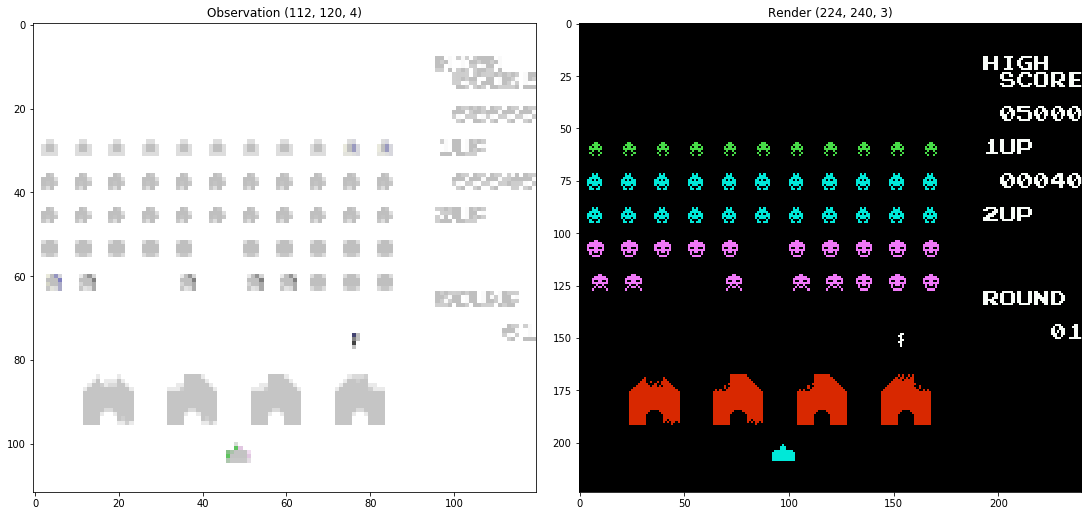

In [0]:
# compare obs and render of random frames
fig, axes = plt.subplots(1,2,figsize=(15, 15), constrained_layout=True)
index = np.random.choice(range(len(frames)))
img1 = obsFrames[index].squeeze()
img2 = frames[index].squeeze()
axes[0].imshow(img1, cmap='gray')
axes[1].imshow(img2)
axes[0].set_title('Observation {}'.format(img1.shape))
axes[1].set_title('Render {}'.format(img2.shape))
fig.show()

Unpacks the four stacked observation frames so you can see them all.

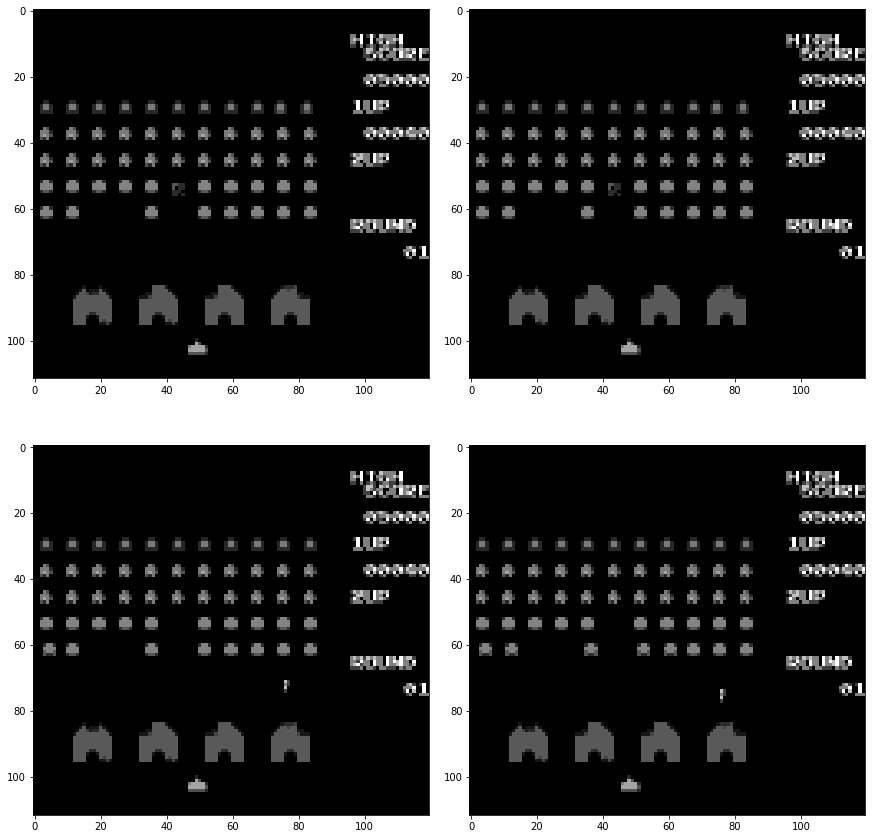

In [0]:
fig, axes = plt.subplots(2,2,figsize=(12, 12), constrained_layout=True)
axes = axes.flatten()
for i in range(4):
  axes[i].imshow(obsFrames[index][:, :, i], cmap='gray')
